In [1]:
import numpy as np 
import math
from scipy.sparse import coo_matrix
import networkx as nx
import random
import matplotlib.pyplot as plt
plt.style.use('default')

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit.primitives import Sampler, BackendSampler
from qiskit import Aer, QuantumRegister
from qiskit.circuit import QuantumCircuit

from os.path import dirname, abspath
import sys
parent_dir = dirname(dirname(abspath(' ')))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from src.optimizer.Quantum_Optimizer_FGSR_b import *
from src.bitflip_strategy.Local_Search_QUBO import local_search

import warnings
warnings.simplefilter('ignore')

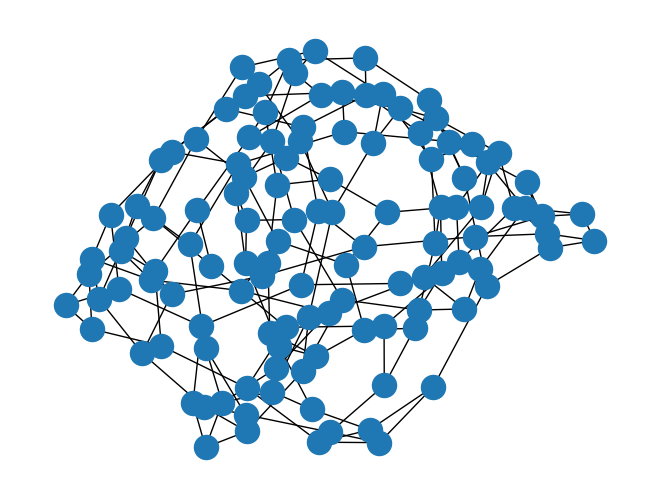

In [2]:
num_nodes = 120
degree = 3
random_seed = 3
weight_type = 'one'
#weight_type = 'binary'

graph = nx.random_regular_graph(degree, num_nodes, random_seed)

if weight_type=='one':
    for i,j in graph.edges():
        graph[i][j]['weight'] = 1
elif weight_type=='binary':
    for i,j in graph.edges():
        graph[i][j]['weight'] = random.randint(2)*2-1

nx.draw(graph)

In [3]:
N = num_nodes

In [4]:
qubo = {
    (i,i): 0 for i in graph.nodes()
}

for i,j in graph.edges():
    w = graph[i][j]['weight']
    if i>j:
        qubo[j,i] = 2 * w
    else:
        qubo[i,j] = 2 * w
    qubo[i,i] -= w
    qubo[j,j] -= w

In [5]:
Q_data = []
for key, val in qubo.items():
    Q_data.append([key[0], key[1], val])
Q_data = np.array(Q_data).astype(float)

Q = coo_matrix((Q_data[:, 2], (Q_data[:, 0], Q_data[:, 1])), shape=(N, N))

In [6]:
mdl = QuadraticProgram('QUBO')
for i in range(N):
    mdl.binary_var(name = f'x_{i}')
mdl.minimize(quadratic=Q)

cplex_result = CplexOptimizer().solve(mdl)
refval = cplex_result.fval

print(f'reference value: {refval:.3f}')

reference value: -163.000


In [7]:
num_qubits = N

print(f'number of system qubits: {num_qubits}')

number of system qubits: 120


In [8]:
objective = lambda x: x@Q@x

In [9]:
# max number of random flips for each bitstring
n_flips = 50

def search(x):
    x = local_search(x, Q=Q_data, n_flips=n_flips)
    return np.asarray(x, dtype=int)

In [10]:
n_reps = 2

q = QuantumRegister(num_qubits, name='q')
sub_qc = QuantumCircuit(q)
qc_params = ParameterVector(name='theta', length=num_qubits*n_reps)

for l in range(n_reps):
    k = 0
    while 2*k < num_qubits-1:
        sub_qc.cz(q[2*k], q[2*k+1])
        k += 1
            
    k = 0
    while 2*k+1 < num_qubits-1:
        sub_qc.cz(q[2*k+1], q[2*k+2])
        k += 1

    for k in range(num_qubits):
        sub_qc.ry(qc_params[l*num_qubits+k], q[k])

    sub_qc.barrier()

In [11]:
shots = 2**10
backend = Aer.get_backend('aer_simulator_matrix_product_state')

sampler = BackendSampler(backend=backend)
sampler.set_options(shots=shots)

print(f'shots = {shots}')

shots = 1024


In [12]:
# configure
alpha = 0.4
max_epoch = 1
restart_s = 0.8
restart_std = 0

In [13]:
QuantumSolver = QuantumOptimizer()
QuantumSolver.set_optimizer(num_qubits, sub_qc, sampler)

QuantumSolver.run(
    objective = objective,
    search = search,
    alpha = alpha,
    random_update = True,
    max_epoch = max_epoch,
    restart_s = restart_s,
    restart_std = restart_std,
    refval = refval,
    intermediate_result_display = True
    )

epoch = 0 	 step = 0 	 objval = -156.000 	 cvar = -96.583   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = -160.000 	 cvar = -148.998   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = -161.000 	 cvar = -152.300   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = -161.000 	 cvar = -153.361   	 s-prob = 0.000e+00
epoch = 0 	 step = 1 	 objval = -162.000 	 cvar = -153.332   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = -163.000 	 cvar = -154.234   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = -163.000 	 cvar = -154.956   	 s-prob = 2.930e-03
epoch = 0 	 step = 1 	 objval = -163.000 	 cvar = -154.507   	 s-prob = 3.906e-03
epoch = 0 	 step = 2 	 objval = -163.000 	 cvar = -154.837   	 s-prob = 3.906e-03
epoch = 0 	 step = 3 	 objval = -163.000 	 cvar = -154.793   	 s-prob = 1.953e-03
epoch = 0 	 step = 4 	 objval = -163.000 	 cvar = -155.215   	 s-prob = 9.766e-04
epoch = 0 	 step = 5 	 objval = -163.000 	 cvar = -154.980   	 s-prob = 2.930e-03
epoch = 0 	 step 

In [14]:
result = QuantumSolver.elog

L1 = [3*i+1 for i in range(len(result))]
L2 = list(result)
L3 = list(QuantumSolver.plog)
L4 = list(QuantumSolver.log)

In [16]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.default'] = 'it'

fig, ax = plt.subplots(figsize=(10, 4))
ax2 = ax.twinx()

ax.plot(L1, L2, color='navy', linewidth=1, label='Mean (Cost)')
ax.plot(L1, L4, color='darkgreen', linewidth=1, label='Best Sampled Value')

ax.set_ylabel('Cost (CVaR)')
ax.set_xlabel('Eval Count')

ax.hlines(refval, xmin=0, xmax=0, color='darkorange', label='Mean (Probability)')
ax.hlines(refval, xmin=1, xmax=L1[-1], color='grey', linestyle='dashed', linewidth=1, label='Optimal Value')
ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)

ax2.plot(L1, L3, color='darkorange', linewidth=1)
ax2.set_ylabel('Probability')
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.show()